In [3]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import xml.etree.ElementTree as ET

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
%matplotlib inline

In [4]:
def load_image_into_numpy_array(path):
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data)).convert("RGB")
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np, boxes, classes, scores, category_index, figsize=(12, 16),
                    image_name=None):
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(image_np_with_annotations, boxes,
      classes, None, category_index, use_normalized_coordinates=True, min_score_thresh=0.8)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

In [7]:
def get_images_n_annotations(path):
    names = os.listdir(path)
    img_names = [(os.path.join(path, name)) for name in names if not names.index(name)%2]
    ann_names = [(os.path.join(path, name)) for name in names if names.index(name)%2]
    images = []
    annotations = []
    for img_name, ann_name in zip(img_names, ann_names):
        img = load_image_into_numpy_array(img_name)
        images.append(img)
        ann_tree = ET.parse(ann_name)
        boxes = []
        labels = []
        lab_leg = {'apple': 1, 'banana':2, 'orange':3}
        root = ann_tree.getroot()
        for objects in root.findall("object"):
            labels.append(lab_leg[objects[0].text])
            for bndbox in objects.findall("bndbox"):
                listbnd = list(bndbox)
                boxes.append([int(listbnd[1].text)/img.shape[0], int(listbnd[0].text)/img.shape[1], int(listbnd[3].text)/img.shape[0], int(listbnd[2].text)/img.shape[1]])
        bndbox = np.array(boxes, dtype=np.float32)
        labels = np.array(labels, dtype=np.int64)
        target = {}
        target['boxes'] = bndbox
        target['labels'] = labels
        annotations.append(target)
    return images, annotations

C:\Python\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


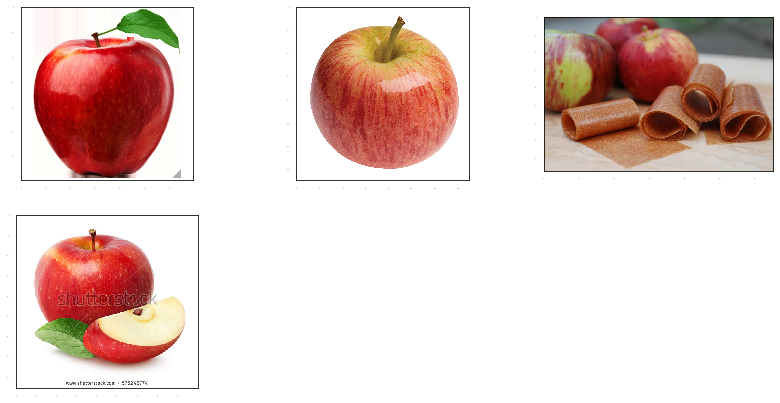

In [8]:
folder_path = r"D:\Datasets\Apple obj-det\train"
train_images_np, annotations = get_images_n_annotations(folder_path)

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np[:4]):
    plt.subplot(2, 3, idx+1)
    plt.imshow(train_image_np)
plt.show()

In [11]:
gt_boxes = [an["boxes"] for an in annotations]
num_classes = 3
category_index = {1: {'id': 1, 'name': 'apple'}, 2: {'id': 2, 'name': 'banana'}, 3: {'id': 3, 'name': 'orange'}}
labels = [an["labels"] for an in annotations]
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np, label) in zip(train_images_np, gt_boxes, labels):
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')
# print(np.array(train_image_tensors).shape)
# print(np.array(gt_classes_one_hot_tensors).shape)
# print(np.array(gt_box_tensors).shape)
print(gt_box_tensors[0])

Done prepping data.
tf.Tensor([[0.04297994 0.02292264 1.         0.94842404]], shape=(1, 4), dtype=float32)


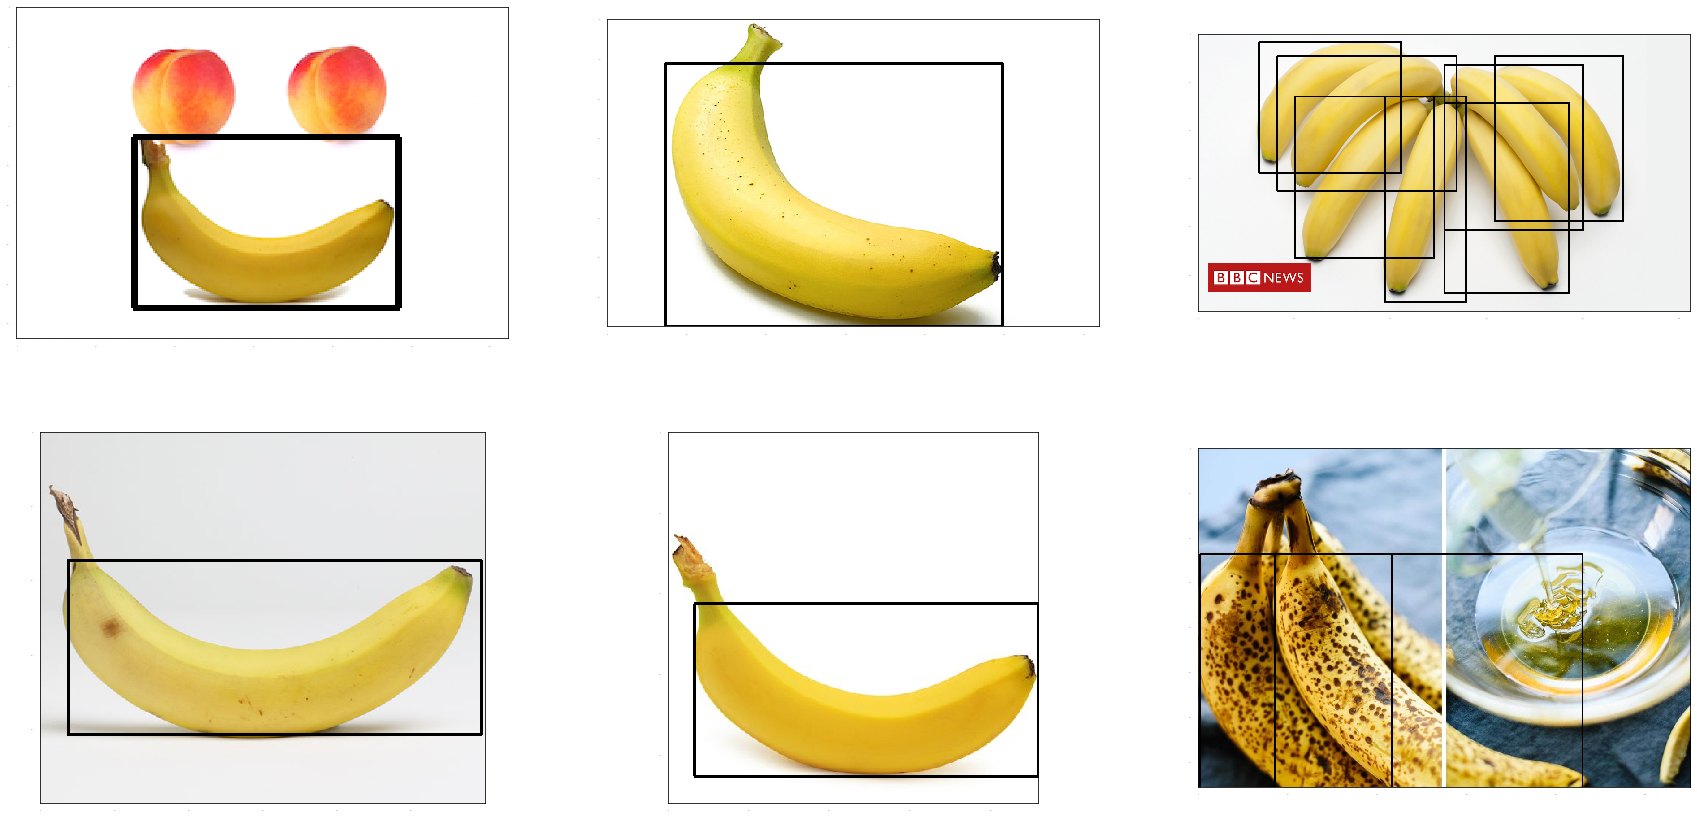

In [13]:
plt.figure(figsize=(30, 15))
i = 0
for idx in range(100, 106):
    i+=1
    dummy_scores = np.array([1.0, 0.0, 0.0], dtype=np.float32)
    plt.subplot(2, 3, i)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, 
        category_index)
plt.show()

In [14]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 3
pipeline_config = 'C:/Programming/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [17]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 1000

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    """Get a tf.function for training step."""

    # Use tf.function for a bit of speed.
    # Comment out the tf.function decorator if you want the inside of the
    # function to run eagerly.
    @tf.function(experimental_relax_shapes=True)
    def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
        """A single training iteration.

        Args:
          image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
            Note that the height and width can vary across images, as they are
            reshaped within this function to be 640x640.
          groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
            tf.float32 representing groundtruth boxes for each image in the batch.
          groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
            with type tf.float32 representing groundtruth boxes for each image in
            the batch.

        Returns:
          A scalar tensor representing the total loss for the input batch.
        """
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
              [detection_model.preprocess(image_tensor)[0]
               for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss
    return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Note that we do not do data augmentation in this demo.  If you want a
    # a fun exercise, we recommend experimenting with random horizontal flipping
    # and random cropping :)
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches) + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


batch 0 of 1000, loss=1.6709111


batch 10 of 1000, loss=1.1893458
batch 20 of 1000, loss=1.2544105
batch 30 of 1000, loss=0.6785681
batch 40 of 1000, loss=0.6997218
batch 50 of 1000, loss=0.88806283
batch 60 of 1000, loss=0.9424144
batch 70 of 1000, loss=0.51301116
batch 80 of 1000, loss=0.77718043
batch 90 of 1000, loss=0.6584666
batch 100 of 1000, loss=6.9115663
batch 110 of 1000, loss=1.878308
batch 120 of 1000, loss=5.2428274
batch 130 of 1000, loss=1.2122337
batch 140 of 1000, loss=1.312692
batch 150 of 1000, loss=0.7145535
batch 160 of 1000, loss=0.60412335
batch 170 of 1000, loss=0.56249064
batch 180 of 1000, loss=1.2647517
batch 190 of 1000, loss=1.4541821
batch 200 of 1000, loss=0.89803827
batch 210 of 1000, loss=1.1279265
batch 220 of 1000, loss=1.9734806
batch 230 of 1000, loss=0.7488233
batch 240 of 1000, loss=0.7978955
batch 250 of 1000, loss=0.48697716
batch 260 of 1000, loss=0.57612175
batch 270 of 1000, loss=0.9555392
batch 280 of 1000, loss=0.612936
batch 290 of 1000, loss=1.2330649
batch 300 of 1000,

In [19]:
test_image_dir = r'D:\Datasets\Apple obj-det\test'
test_images_np = []
names = os.listdir(test_image_dir)
img_names = [(os.path.join(test_image_dir, name)) for name in names if not names.index(name)%2]
for image_path in img_names[:50]:
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)

    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20))